# Project - First Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde    # Just to plot distribution of valuations

### The first thing to do is to code the environment.

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [3]:
class PricingEnvironmentSingleProduct:
    def __init__(self, valuations, cost):
        self.valuations = valuations
        self.cost = cost

    def round(self, p_t):
        num_of_sales = np.sum(self.valuations >= p_t)       # Count how many customers are willing to pay at least p_t
        reward = (p_t - self.cost) * num_of_sales           # Count the profit subtracting the cost from the price for each sale
        return num_of_sales, reward

### Now define the setting...

In [4]:
# --- Setting - Things that the seller needs to know --- #

min_p = 0                                   # Minimum price in euro
max_p = 5                                   # Maximum price in euro

T = 10000                                                           # Number of rounds
N = 1                                                               # Number of products
P = np.linspace(min_p, max_p, int((max_p - min_p) / 0.5) + 1)       # Prices from min_p to max_p inclusive, stepping by 0.5
B = 20000                                                           # Number of buyers

# --- Setting - Things that the environment needs to know --- #

num_of_buyers = ( int ) ( B / T * 50 )                                          # Assuming I can sell on average B / T * 50 items per round
assert not num_of_buyers < 1, "Number of buyers must be greater than 0"         # Assert that the number of buyers is greater than 0
value = 3.00                                                                    # "Real value" of the product
cost = 2.00                                                                     # Cost of the product
assert cost < value, "Cost must be less than the value of the product"          # Assert that cost is less than value
valuations = np.random.normal(loc=value, scale=1.0, size=num_of_buyers)         # Generate random valuations around 3.50€

# --- Setting - Define the environment --- #

env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)

### Let us visualize our setting.

Max expected profit:  46.0
...at price:  3.0


Text(0, 0.5, 'Density')

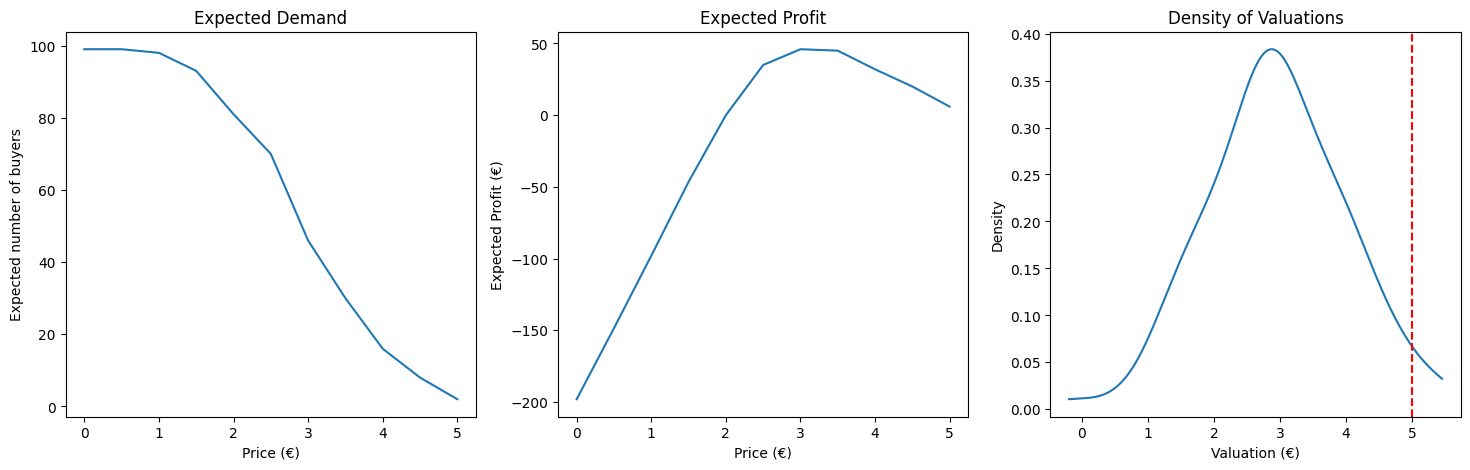

In [5]:
# --- Compute expected demand and expected profit --- 

expected_demand = [np.sum(valuations >= p) for p in P]
expected_profit = [(p - cost) * d for p, d in zip(P, expected_demand)]

print("Max expected profit: ", max(expected_profit))
print("...at price: ", P[np.argmax(expected_profit)])

# --- Plot ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot expected demand
axs[0].plot(P, expected_demand)
axs[0].set_title("Expected Demand")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Expected number of buyers")

# Plot expected profit
axs[1].plot(P, expected_profit)
axs[1].set_title("Expected Profit")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Expected Profit (€)")

# Plot valuations density (KDE)
x_vals = np.linspace(min(valuations), max(valuations), 1000)
axs[2].plot(x_vals, gaussian_kde(valuations)(x_vals))
axs[2].axvline(x=max_p, color='red', linestyle='--', label=f"max_p = {max_p}€")  # Max price for seller
axs[2].set_title("Density of Valuations")
axs[2].set_xlabel("Valuation (€)")
axs[2].set_ylabel("Density")


### How can I interact with this environment? We use Agents.

In [6]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass